# K-means

Vamos pegar uma intuição do k-means inicialmente. Para tanto, vamos gerar algumas bolhas (como se fossem agrupamentos pra entender como o k-means poderia ser usado para agrupar esses dados). 

In [1]:
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
from sklearn.datasets import make_blobs

Matplotlib is building the font cache; this may take a moment.


Agora, vamos criar nossos dados. Especificamos a localização dos centróides e definimos o desvio padrão dos dados para cada cluster

In [2]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

Agora usamos o método make_blobs para criar as bolhas baseadas nas informações que passamos parâmetros. O método retorna os dados gerados bem como o rótulo de cada um (seu cluster).

In [3]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

Podemos criar uma função para visualizar os dados

In [4]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

E agora, fazemos o plot das bolhas:


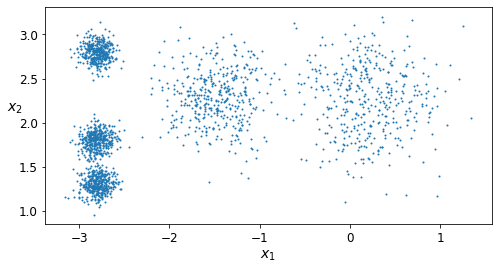

In [5]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

Agora, a ideia é treinar o k-means nesses dados e verificar se ele encontra esses grupos

In [6]:
from sklearn.cluster import KMeans

Para treinar o k-means, definimos o número de k. A partir desses dados, 5 é um número adequado. Entretanto, em problemas reais, a definição de k não é tão simples assim, como já vimos.

In [7]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

In [8]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

Podemos comparar os centróides obtidos pelo k-means com os centróides que definimos previamente ao criar os dados. Isso nos dará uma ideia da qualidade dos clusters formados:

In [9]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

Algo interessante de se fazer é plotar as fronteiras de decisão que o algoritmo encontrou e comparar com o plot original dos dados, o que nos permite identificar erros de atribuição a um determinado cluster.

In [11]:
#criando as funções para visualizar as fronteiras de decisão
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Agora podemos fazer o plot. O que vamos obter é conhecido como Diagrama de Voronoi, uma forma de representar clusters. 

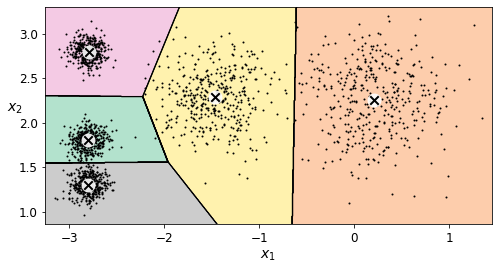

In [12]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Compare essa figura com a figura original das bolhas. Consegue identificar erros de atribuição?

Fazer a predição de novas amostras é particularmente simples também:

In [13]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

# O Algoritmo K-means

Depois de entendermos intuitivamente o K-means, é hora de nos aprofundarmos na maneira em que ele constrói clusters.

Suponha que seja fornecido os centróides. Dessa maneira, poderíamos facilmente rotular todas as intâncias no dataset atribuindo a cada uma delas ao cluster cujo centróide seja o mais próximo. 

Alternativamente, se todos os rótulos das amostras foram fornecidos, poderíamos localizar os centróides calculando a média de todas as amostras para cada cluster

Mas e se nada disso for fornecido? 

Podemos posicionar os centróides de maneira aleatória (selecionando k amostras aleatóriamente e usando suas localizações como centróides). Então, rotulamos as instâncias, atualizamos os centróides, rotulamos as instâncias, atualizamos os centróides e assim sucessivamente até que os centróides parem de se mover. 

Vamos executar o K-means para 1, 2 e 3 iterações e ver como os centróides vão se movendo bem como as instâncias atualizando seus rótulos

In [14]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

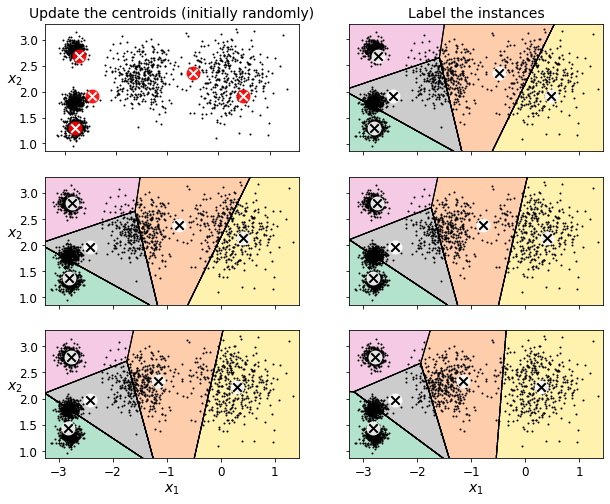

In [15]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

Vimos que, em poucas iterações, o k-means se aproximou da solução ótima. Entretanto, como vimos, o k-means é sensível a inicialização dos centróides, o que signifca que ele pode não convergir para a solução ótima. Vamos entender como podemos encontrar a solução ótima

### Métodos de Inicialização dos Centróides

Se sabmos de antemão onde aproximadamente os centróides devem ser posicionados, podemos setar o parâmetro *init* a partir de um Numpy array e setar *n_init* igual a 1

In [16]:
good_init = np.array([[-3,3],[-3,2],[-3,1],[-1,2],[0,2]])
kmeans = KMeans(n_clusters=5, init=good_init, n_init=1)
kmeans.fit(X)

KMeans(init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       n_clusters=5, n_init=1)

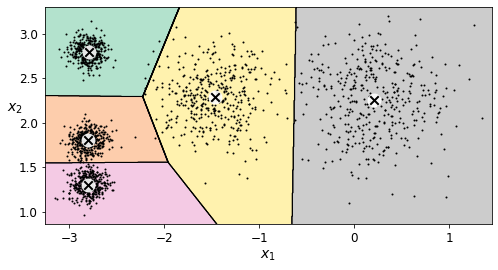

In [17]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

Outra solução é executar o algoritmo múltiplas vezes com diferentes inicializações aleatórias e guardar a melhor solução, mas como sabemos que uma solução é a melhor?

Temos uma métrica de performance que nos fornece essa informação: inercia do modelo, obtida através do parâmetro *inertia_*. Essa métrica nada mais é que distância média quadrática entre cada instância e o centróide mais próximo. 

In [18]:
kmeans.inertia_

211.5985372581684

### Encontrando o número ótimo de clusters

Até o momento, definimos o número de cluster (k) igual a 5 porque é o número óbvio quando se olha os dados. Entretanto, de modo geral, não será fácil saber definir k e os resultados podem ser bem ruins se escolhermos o número incorreto de k. 

Observe o exemplo quando usamos k=3 e depois k=8

In [19]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

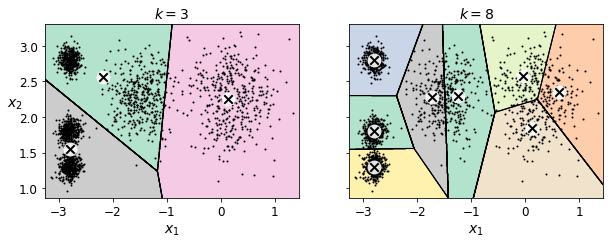

In [20]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.show()

E se usarmos a inércia para definir o número ótimo de clusters? 

In [21]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

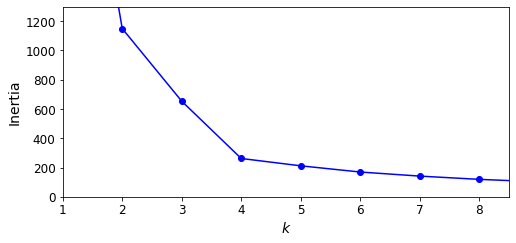

In [22]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.axis([1, 8.5, 0, 1300])
plt.show()

Qual o problema dessa solução?

Não podemos simplesmente usar o valor de k que minimiza a inércia visto que ela continuará diminuindo à medida que aumentamos o valor de k. 

De fato, quanto mais clusters existem, mais perto cada instância ficará do seu centróide e, portanto, menor o valor da iníercia. 

#### Elbow

Entretanto, ainda podemos usar a inércia para definir um valor adequado de clusters. Ao analisarmos o gráfico, observamos que o valor na inércia cai drásticamente à medida que aumentamos o valor de k até 4 e, então, o valor da inércia diminui muito mais lentamente a partir daí. Esta curva possui vagamente uma forma de um braço e possui um "cotovelo" (elbow) quando k=4. Assim, poderíamos usar k=4 para uma solução adequada

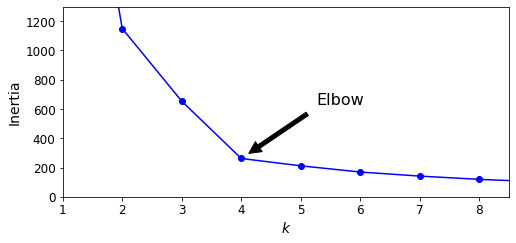

In [23]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.show()

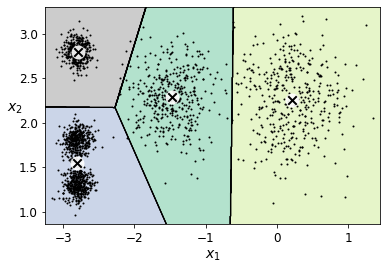

In [24]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

#### Silhouette

Uma outra, e melhor, abordagem para determinar o número de cluster é a partir do *silhouette coefficient*. Como vimos, esse coeficiente é dado pela seguinte equação:

$\frac{(b-a)}{max(a,b)}$

em que:

* é a distância média para outras amostras no mesmo cluster (distância média intra-cluster)
* 𝑏 é a distância média do cluster mais próximo (distância média para as amostras do próximo cluster mais próximo)

Para calcular o *silhouette score* podemos usar a função de mesmo nome da Scikit-Learn, fornecendo todas as amostras do dataset e seus respectivos rótulos aos quais foram atribuídos:

In [25]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.655517642572828

Podemos comparar o valor desse score para diferentes números de clusters:

In [26]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

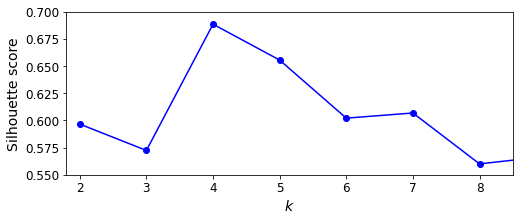

In [27]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

Como podemos ver, esta visualização é muito mais rica que a anterior (usando *inertia*). Embora confirme que k=4 é uma ótima escolha (da mesma maneira que o gráfico anterior), mostra também que k=5 é uma excelente opção e muito melhor que k=6 ou k=7, o que não é visível quando usamos inércia.

# Hierarchical Cluster

Para começar, vamos criar alguns dados para entender a formação dos dendrogramas:

In [28]:
import numpy as np

X = np.array([[5,3],
    [10,15],
    [15,12],
    [24,10],
    [30,30],
    [85,70],
    [71,80],
    [60,78],
    [70,55],
    [80,91],])

Agora, vamos plotar esses dados para visualizar seu comportamento:

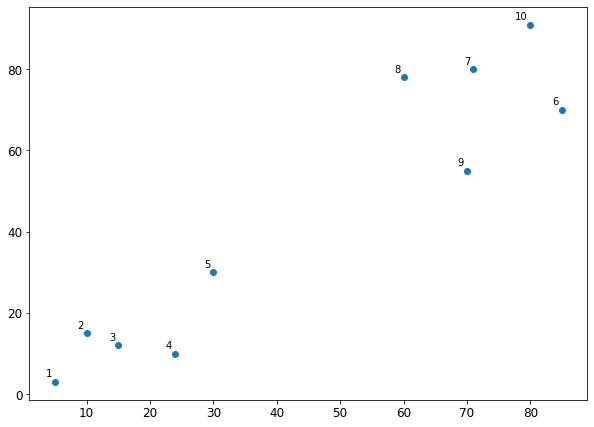

In [29]:
labels = range(1, 11)
plt.figure(figsize=(10, 7))
plt.subplots_adjust(bottom=0.1)
plt.scatter(X[:,0],X[:,1], label='True Position')

for label, x, y in zip(labels, X[:, 0], X[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

É possível ver que esses dados formam dois cluster. A partir deles, vamos, então, desenhar os dendrogramas. A princípio, iremos usar a biblioteca scipy (de onde vem o numpy) para isso. Depois, vamos para Scikit-Learn

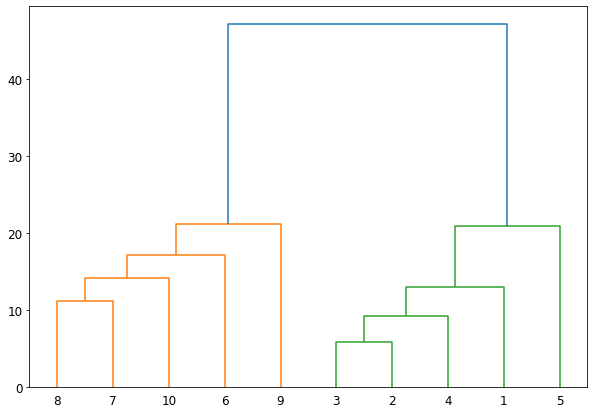

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X, 'single')

labelList = range(1, 11)

plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

O algoritmo começa encontrando os dois pontos mais próximos um ao outro baseado na distância euclidiana. No caso, os pontos 2 e 3 são os mais próximos, por isso eles formam o primeiro cluster. 

Nos dendrogramas, a altura das barras de cada agrupamento determina o valor da distância euclidiana. 

## Hclust usando Scikit-Learn

Vamos agora usar a scikit learn para criar um cluster hierárquico. 

Primeiro, vamos criar os dados:

In [34]:
X = np.array([[5,3],
    [10,15],
    [15,12],
    [24,10],
    [30,30],
    [85,70],
    [71,80],
    [60,78],
    [70,55],
    [80,91],])

In [32]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=int64)

Observe que setamos o número de cluster *n_clusters* igual a 2, usamos a distância euclidiana para calcular a distância entre os pontos e linkage estamos usando a opção "ward", que se refere a minimização da variância dos clusters sendo agrupados. As outras opções são as que vimos em sala: single linkage, complete linkage e average linkage

O método fit_predict() retorna o rótulo de cada instância

Podemos plotar os dados originais pintando cada instância de acordo com o cluster a que ela foi atribuída:

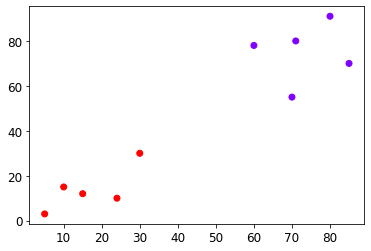

In [33]:
plt.scatter(X[:,0],X[:,1], c=cluster.labels_, cmap='rainbow')

# DBSCAN

In [35]:
from sklearn.datasets import make_moons
from sklearn.cluster import DBSCAN

In [36]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [37]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [38]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

Note que alguns rótulos possuem valor igual a -1, o que significa que eles são considerados anomalias pelo algoritmo

In [39]:
dbscan.components_[:3] #core instances

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

Vamos treinar um novo DBSCAN, mas agora usando eps = 0.2 e comparar com o primeiro

In [40]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [42]:
#função auxiliar para plotar os cluster
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

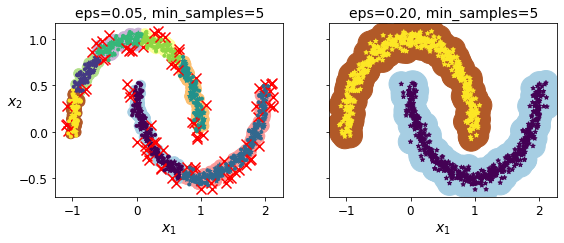

In [43]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

Surpreendentemente, o DBSCAN não possui um método *predict()*, embora possua um método *fit_predict()*. Em outras palavras, não é possível predizer a qual cluster uma nova amostra pertence. Esta decisão de implementação foi feita porque difernetes algoritmos de classificação podem ser melhores para diferentes tarefas, então os autores decidiram deixar o usuário escolher. 

Entretanto, não é difícil de implementar. Por exemplo, podemos treinar um KNN:

In [44]:
from sklearn.neighbors import KNeighborsClassifier

In [45]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

obs: core_sample_indices_ contém os índices das instâncias *core*

In [46]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([6, 0, 3, 2], dtype=int64)

In [47]:
knn.predict_proba(X_new)

array([[0.24, 0.  , 0.  , 0.  , 0.  , 0.  , 0.76],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.3 , 0.7 , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ]])